## Author: Chia-Yun (Sandy) Chiang

# Introduction

In this project, I used regression model to predict the house price in different neighbourhood in Austrilia. First, I did a quick exploratory data analysis to understand the overview of the data. Second, based on the result of EDA, I divided the dataset based on neighbourhood in order to further build model for prediction. Third, according to different attributes of the data, I applied different kinds of regression model and test for the model assumptions to make sure the credibility of the model. Finally, I gave an summary for each neighbourhood for its house price prediction strategies.  

### Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import f_oneway
from scipy.stats import bartlett
from scipy.stats import levene
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Set style
plt.style.use('seaborn-white')
plt.style.use('seaborn-pastel')
plt.rcParams["figure.figsize"] = (24,8)

In [3]:
# Data source
listing_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSgIx5_i2wVcxq8xlN7Hryyyc-lFghd6Vfn-u1pGRKRDtj2KlNIcqVelmoHVTahxlGbI3nUodZRR9Ec/pub?gid=1281598728&single=true&output=csv"

In [4]:
# Read data
listing = pd.read_csv(listing_path)

## 1. Overview of dataset

In [5]:
listing.head(3)

,id,country,state,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
0,3363954,Australia,NSW,BALLINA SHIRE COUNCIL,House,0.00,"$2,900.00",Entire home/apt,3.0,4.0,4.0
1,13048065,Australia,NSW,BALLINA SHIRE COUNCIL,House,1.55,$28.00,Private room,1.0,1.0,1.0
2,1451202,Australia,NSW,BALLINA SHIRE COUNCIL,Guest suite,15.00,$141.00,Entire home/apt,1.0,1.0,1.0


In [6]:
try:
  listing = listing.drop(columns = ["id", "state"])
except:
  print("column already drop or column could not be found.")

In [7]:
listing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3974 entries, 0 to 3973
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 3974 non-null   object 
 1   neighbourhood_cleansed  3974 non-null   object 
 2   property_type           3974 non-null   object 
 3   square_meters           3974 non-null   float64
 4   price                   3974 non-null   object 
 5   room_type               3974 non-null   object 
 6   bathrooms               3969 non-null   float64
 7   bedrooms                3972 non-null   float64
 8   beds                    3973 non-null   float64
dtypes: float64(4), object(5)
memory usage: 279.5+ KB


In [8]:
listing.isnull().sum()

country                   0
neighbourhood_cleansed    0
property_type             0
square_meters             0
price                     0
room_type                 0
bathrooms                 5
bedrooms                  2
beds                      1
dtype: int64

In [9]:
# Drop records which contain NA value
listing = listing.dropna(how="any", axis = 0)

In [10]:
listing.isnull().sum()

country                   0
neighbourhood_cleansed    0
property_type             0
square_meters             0
price                     0
room_type                 0
bathrooms                 0
bedrooms                  0
beds                      0
dtype: int64

In [11]:
listing.shape

(3966, 9)

In [12]:
# Clean price column
listing["price"] = listing["price"].str.replace("$","").str.replace(",","").astype(float)

In [13]:
# Show descripitive statistic - numerical column
listing.describe().round()

,square_meters,price,bathrooms,bedrooms,beds
count,3966.0,3966.0,3966.0,3966.0,3966.0
mean,33.0,803.0,2.0,2.0,3.0
std,12.0,886.0,1.0,1.0,2.0
min,0.0,1.0,0.0,0.0,0.0
25%,25.0,200.0,1.0,1.0,1.0
50%,30.0,510.0,1.0,2.0,3.0
75%,35.0,1100.0,2.0,3.0,4.0
max,209.0,11500.0,9.0,12.0,18.0


In [14]:
# Show descripitive statistic - categorical column
obj_list = list(listing.select_dtypes(include = ["object"]).columns)
listing[obj_list].describe()

,country,neighbourhood_cleansed,property_type,room_type
count,3966,3966,3966,3966
unique,1,5,8,3
top,Australia,BYRON SHIRE COUNCIL,House,Entire home/apt
freq,3966,2489,2419,3218


## 2. Explore the dataset

- Since our objective is to make inferences about pricing, let's first check about the correlation coefficient of price.

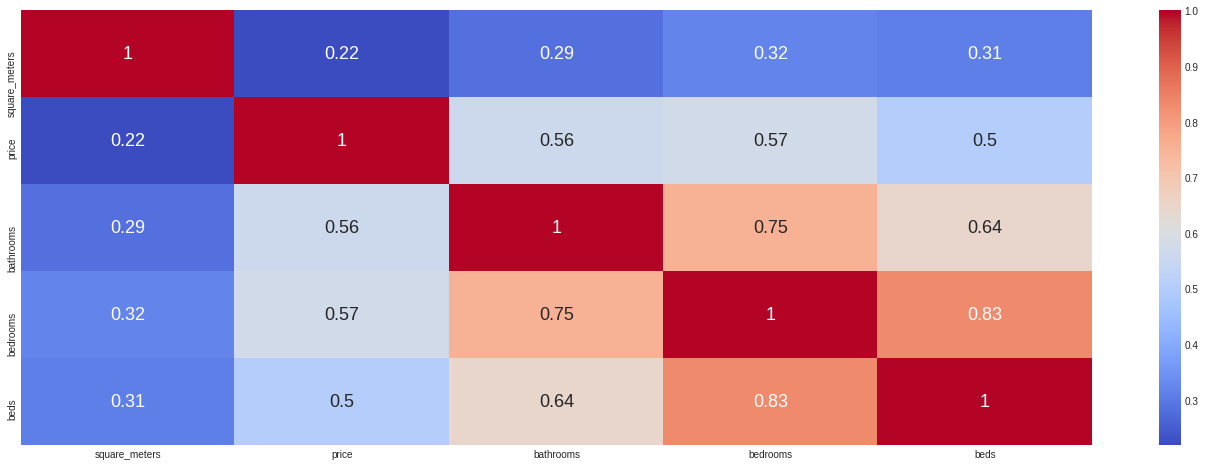

In [15]:
ax = sns.heatmap(listing.corr(), annot = True, cmap="coolwarm", annot_kws = {'size':18})

- All the attributes have low correlation coefficient with price.

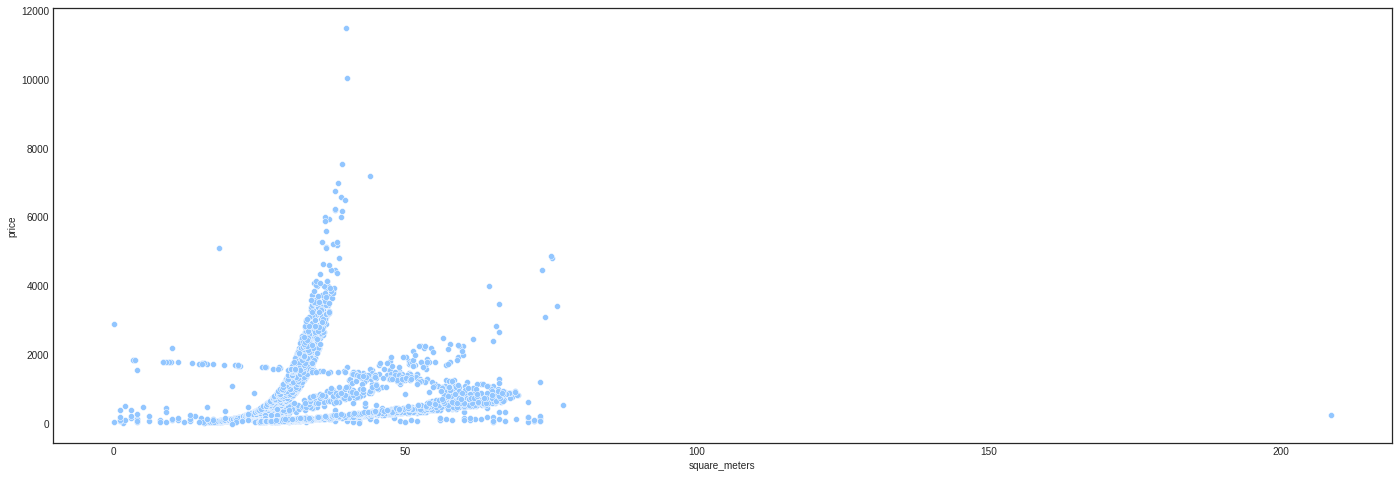

In [16]:
# Visualize the data
ax = sns.scatterplot(x="square_meters", y = "price", data=listing)

In [17]:
# removie outlier
lower = listing["square_meters"].quantile(0.01)
upper = listing["square_meters"].quantile(0.99)
listing = listing.loc[(listing["square_meters"] > lower) & (listing["square_meters"] < upper)]

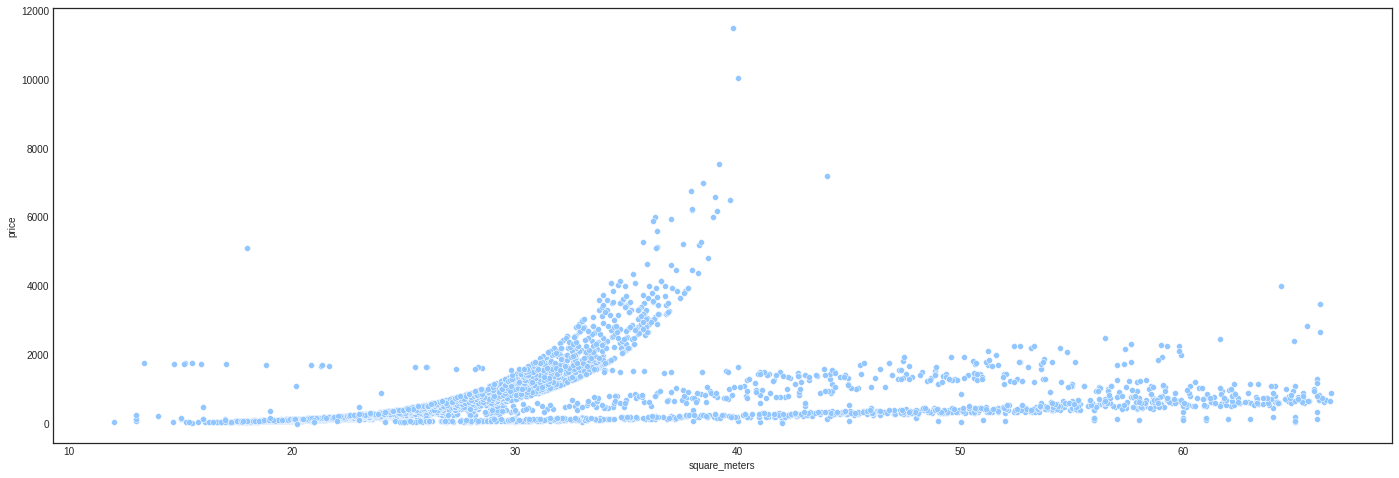

In [18]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing)

- From the above picture, it seems like there are 3~4 trends of the dataset.
- Try to categorize by attributes to see if our data really have different groups of trends.

In [19]:
listing["neighbourhood_cleansed"].value_counts()

BYRON SHIRE COUNCIL        2487
TWEED SHIRE COUNCIL         852
BALLINA SHIRE COUNCIL       445
LISMORE CITY COUNCIL         90
RICHMOND VALLEY COUNCIL      11
Name: neighbourhood_cleansed, dtype: int64

In [20]:
# Subset based on neighbourhood
listing_BSC = listing[listing["neighbourhood_cleansed"]=="BYRON SHIRE COUNCIL"]
listing_TSC = listing[listing["neighbourhood_cleansed"]=="TWEED SHIRE COUNCIL"]
listing_BASC = listing[listing["neighbourhood_cleansed"]=="BALLINA SHIRE COUNCIL"]
listing_LCC = listing[listing["neighbourhood_cleansed"]=="LISMORE CITY COUNCIL"]
listing_RVC = listing[listing["neighbourhood_cleansed"]=="RICHMOND VALLEY COUNCIL"]

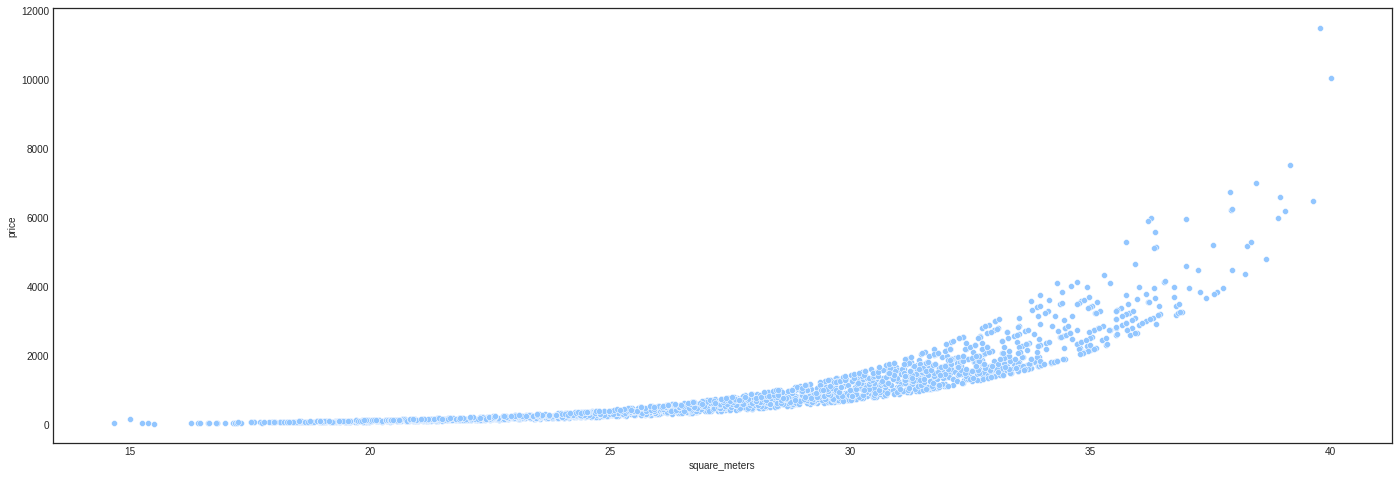

In [21]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_BSC)

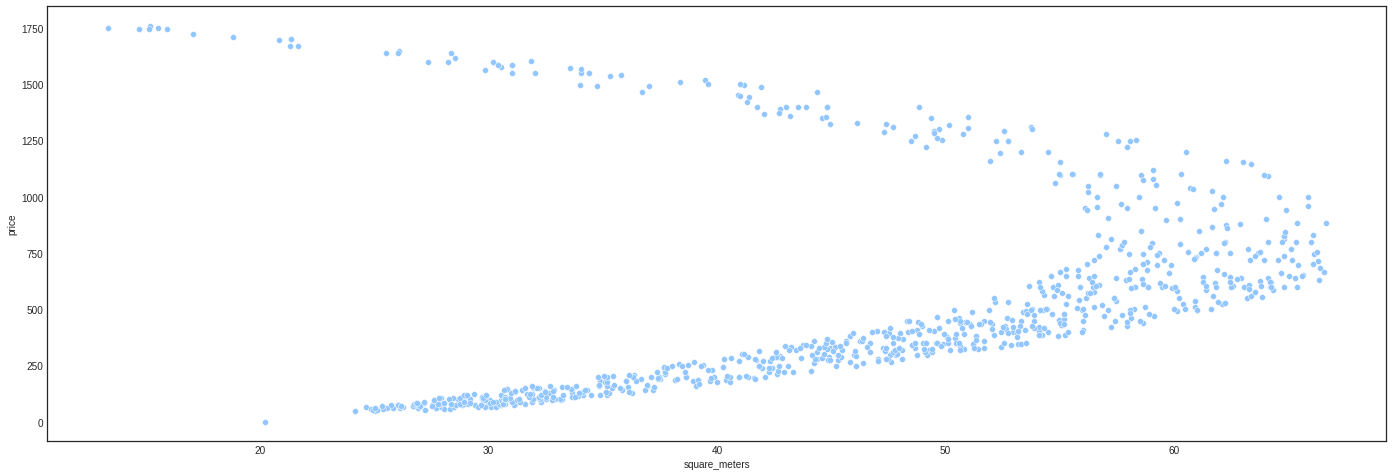

In [22]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_TSC)

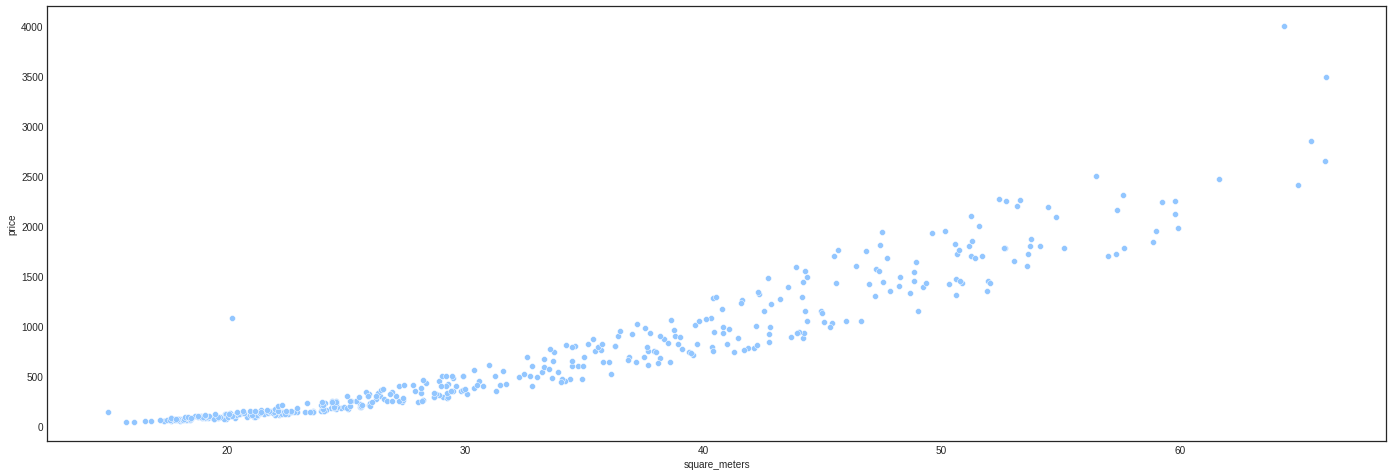

In [23]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_BASC)

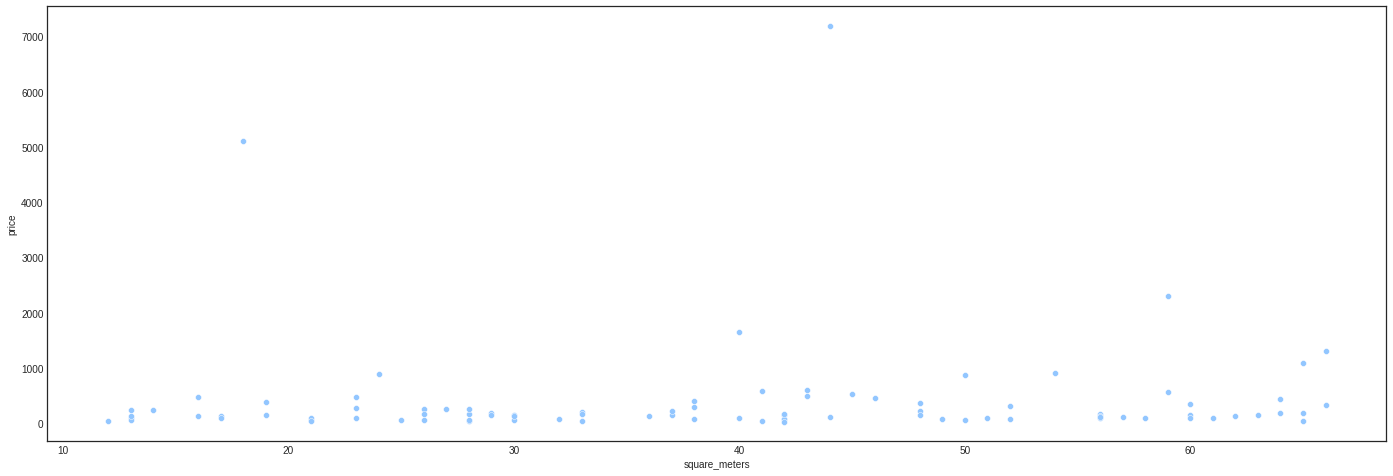

In [24]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_LCC)

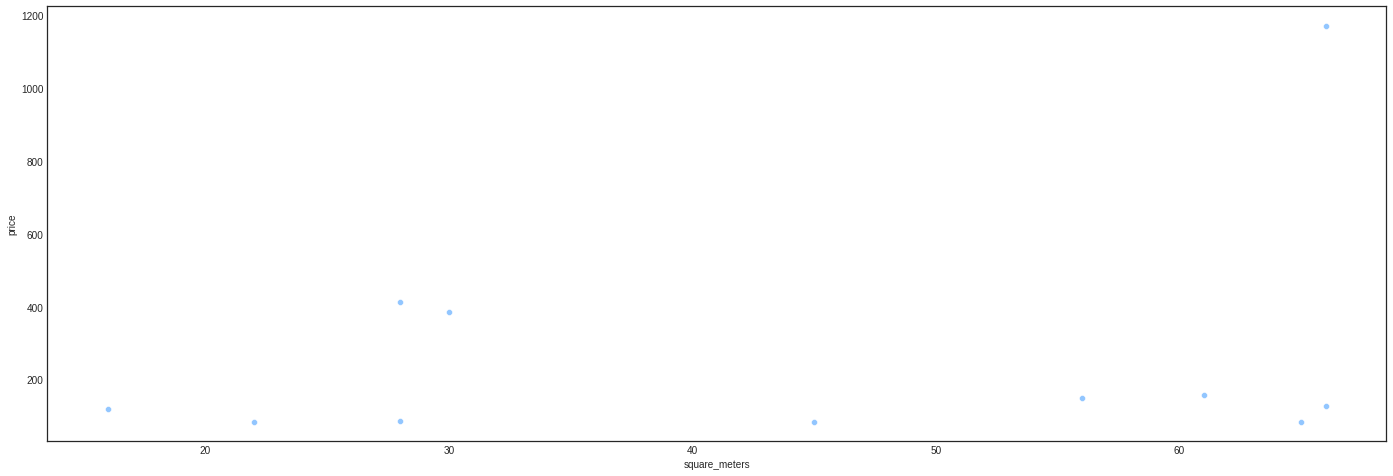

In [25]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_RVC)

- The trends is based on neighbourhood.
- Try to use different price models for different neighbourhoods.

## 3. Build price prediction models for different neighbourhoods.

###  Summary of some key points
### **Assumptions of Linear Regression**
- Linearity: assume that there is a linear relationship between dependent variable(y) and independent variables(X).
> **Test method**: scatter plot for single independent variable; residuals v.s. fitted plot for multiple independent variables.
- Normality: assume that the residuals are normally distributed.
> **Test method**: QQ plot, Anderson-Darling test
- No Multicollinearity: assume that independent variables are not correlated with each others.
> **Test method**: VIF (Variance Inflation Factor)
- No Autocorrelation: assume that there's no autocorrelation of residuals.
> **Test method**: Autocorrelation plot, Durbin-Watson Test
- Homoscedasticity: assume that the reiduals have the same variance
> **Test method**: Residuals v.s. fitted plot


**Code Reference**
- [Testing Linear Regression Assumptions in Python](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/)
- [Verifying the Assumptions of Linear Regression in Python](https://www.youtube.com/watch?v=rw84t7QU2O0&ab_channel=BhaveshBhatt)


### **If the data does not meet the assumptions of linear regression model...**
Try:
- Remove outlier
- Transform the data

** In the following sections, I will first build model for prediction, then test for the assumptions to see if model is reliable, and finally make a brief summary. **

## Define Assumptions Testing function

In [26]:
def test_linearity(x_train, y_train, independent_column, dependent_column):
  ax = sns.regplot(x= x_train[independent_column], y = y_train[dependent_column])

def test_normality(residuals, dependent_column):
  # QQ plot
  fig, ax = plt.subplots()
  _,fit = stats.probplot(residuals[dependent_column], plot=ax, fit=True)

  # Anderson-Darling test
  alpha = 0.05
  p_value = normal_ad(residuals)[1]
  if p_value <= alpha:
    print("residuals is not normally distributed. p value is %.3f (alpha = 0.05)" % p_value)
  else:
    print("residual is normally distriubted. p value is %.3f (alpha = 0.05)" % p_value)

def test_noautocorrelation(residuals):
  # Autocorrelation plot
  acf = smt.graphics.plot_acf(residuals, lags=40, alpha=0.5)
  acf.show()

  # Durbin-Watson Test
  dw_value = durbin_watson(residuals)
  if dw_value < 1.5:
    print("Assumption not meet - positive autocorrelation. dw_statistic is %.3f (alpha=0.05)" % dw_value)
  elif dw_value > 2.5:
    print("Assumption not meet - negative autocorrelation. dw_statistic is %.3f (alpha=0.05)" % dw_value)
  else:
    print("Meet assumption - little or no autocorrelation. dw_statistic is %.3f (alpha=0.05)" % dw_value)

def test_homoscedasticity(residuals, y_pred):
  fig, ax = plt.subplots()
  _ = ax.scatter(y_pred, residuals)

## 3-1 BALLINA SHIRE COUNCIL (BASC) model

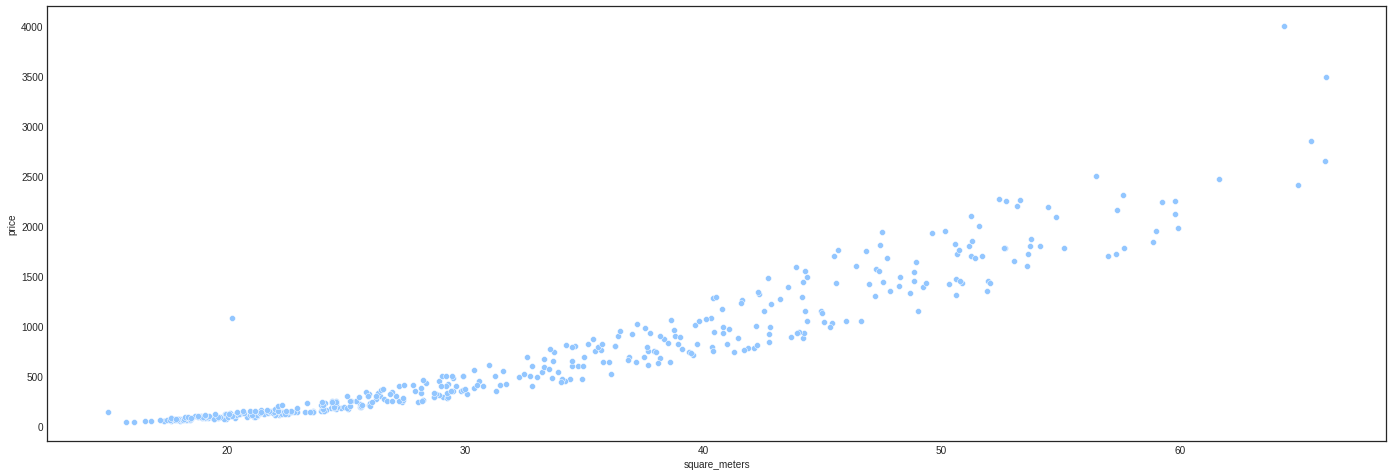

In [27]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_BASC)

- Looks like linear regression

In [28]:
# Removie outlier
lower_BASC = listing_BASC["square_meters"].quantile(0.01)
upper_BASC = listing_BASC["square_meters"].quantile(0.99)
listing_BASC = listing_BASC.loc[(listing_BASC["square_meters"] > lower_BASC) & (listing_BASC["square_meters"] < upper_BASC)]

In [29]:
# Prepare training and testing data
y_BASC = listing_BASC[["price"]]
X_BASC = listing_BASC[["square_meters"]]
X_train_BASC, X_test_BASC, y_train_BASC, y_test_BASC = train_test_split(X_BASC, y_BASC, random_state=1)
# Fit model and predict
lr_model_BASC = LinearRegression()
lr_model_BASC.fit(X_train_BASC, y_train_BASC)
y_pred_BASC = lr_model_BASC.predict(X_test_BASC)
# Evaluation metrics
r2_score_BASC = r2_score(y_test_BASC, y_pred_BASC)
mse_BASC = mean_squared_error(y_test_BASC, y_pred_BASC)
print("BASC model - R squared (R^2): %.2f" % r2_score_BASC)
print("BASC model - Mean Squared Error (MSE): %.2f" % mse_BASC)

BASC model - R squared (R^2): 0.94
BASC model - Mean Squared Error (MSE): 19378.86


### Test for assumptions (BASC)

(1) Linearity

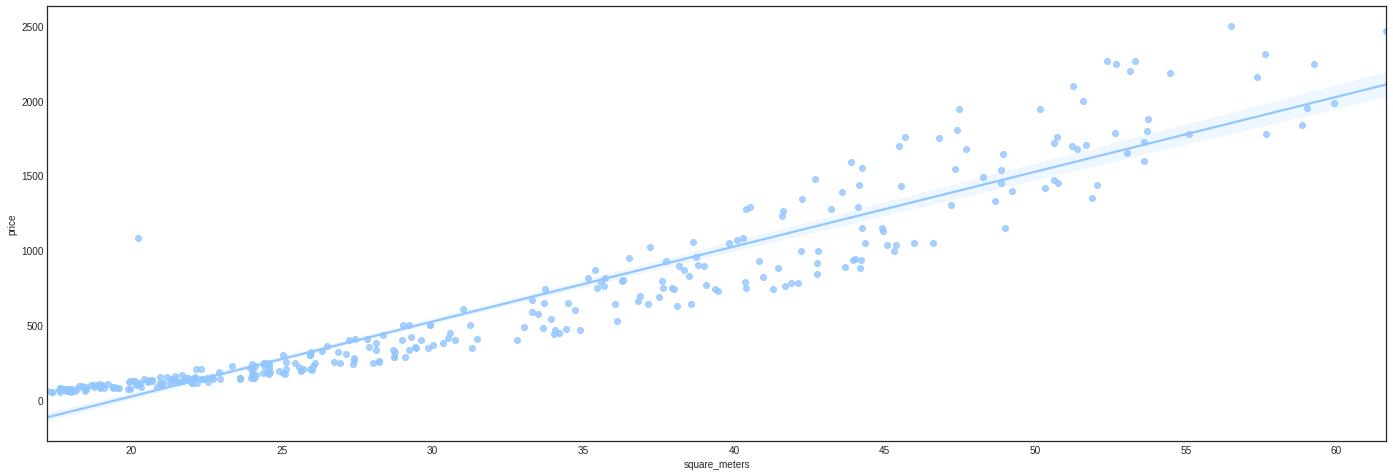

In [30]:
test_linearity(X_train_BASC, y_train_BASC, "square_meters", "price")

- have linear relationship --> ok

(2) Normality

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


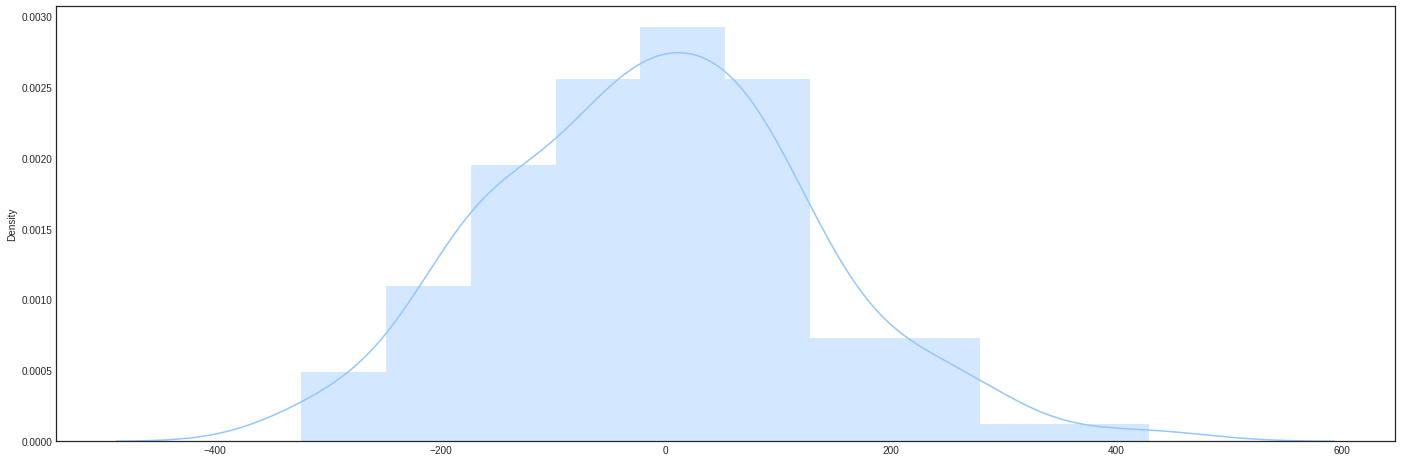

In [31]:
residuals_BASC = y_test_BASC - y_pred_BASC
sns.distplot(residuals_BASC)

residual is normally distriubted. p value is 0.749 (alpha = 0.05)


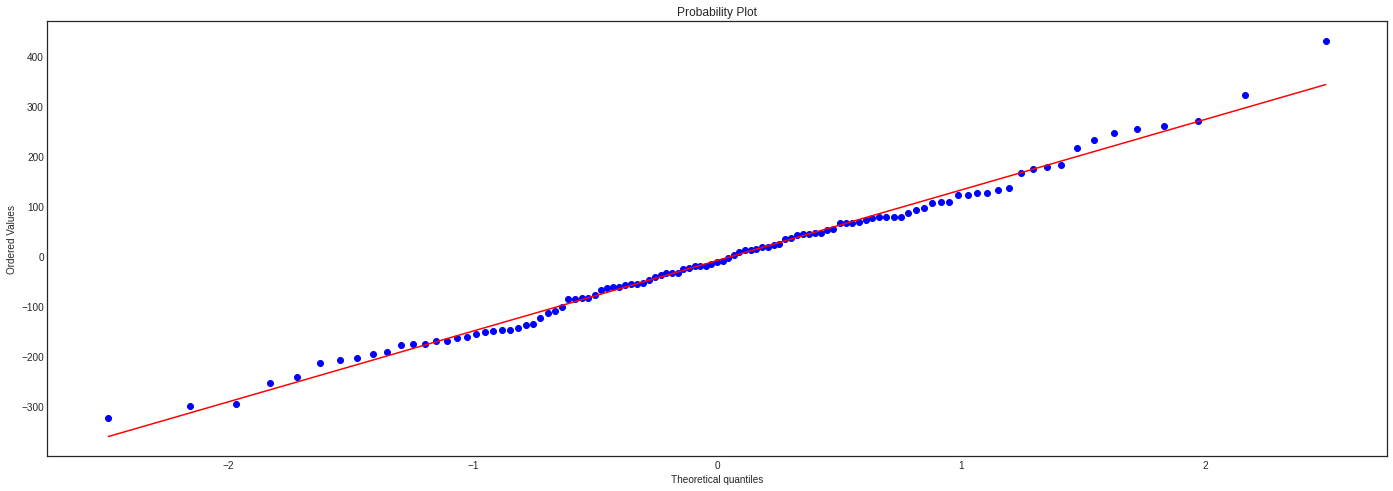

In [32]:
test_normality(residuals_BASC, "price")

- Based on QQ plot & Anderson-Darling test, residuals is normally distributed. --> ok

(3) No Multicollinearity
- Since I only used one predictor in this regression model, there's no need to test this assumption. --> ok

(4) No Autocorrelation

Meet assumption - little or no autocorrelation. dw_statistic is 1.957 (alpha=0.05)


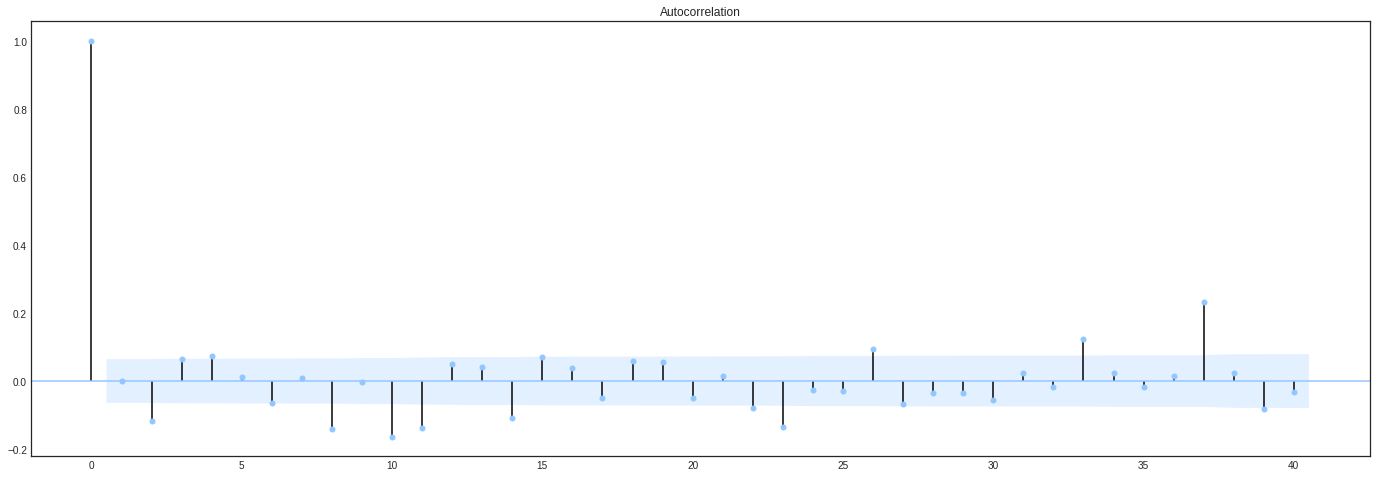

In [33]:
test_noautocorrelation(residuals_BASC)

- According to autocorrelation plot & Durbin-Waston test. There's little or no autocorrelation of residuals. --> ok

(5) Homoscedasticity

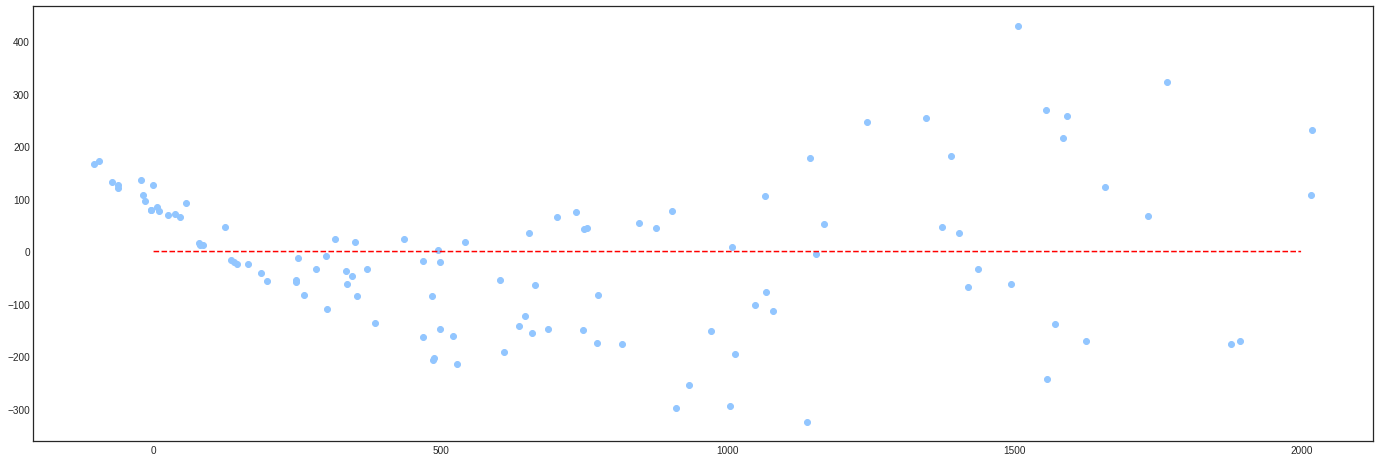

In [34]:
test_homoscedasticity(residuals_BASC, y_pred_BASC)
plt.plot(np.repeat(0, 2000), color='red', linestyle='--')

- There's no obvious variance pattern. --> ok

**BASC model summary**:    
- BASC model has high R^2 (0.94) with MSE equals to 19379. And this model meets all the linear regression assumptions. 
- I would use this model for price prediction in BASC area.

## 3-2 BYRON SHIRE COUNCIL (BSC) Model

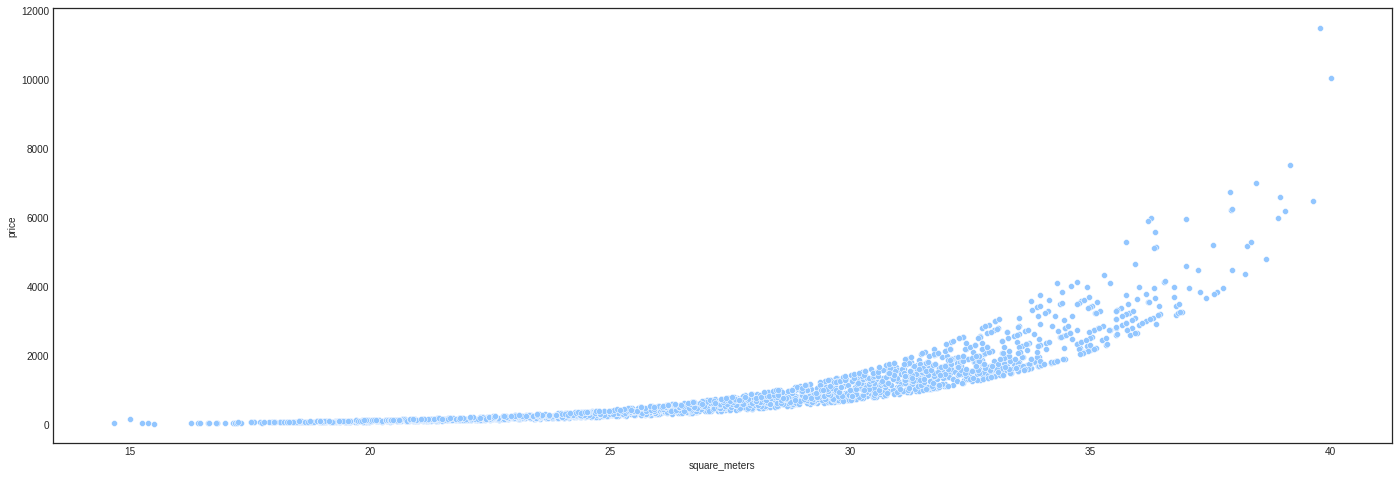

In [35]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_BSC)

In [36]:
# Removie outlier
lower_BSC = listing_BSC["square_meters"].quantile(0.01)
upper_BSC = listing_BSC["square_meters"].quantile(0.99)
listing_BSC = listing_BSC.loc[(listing_BSC["square_meters"] > lower_BSC) & (listing_BSC["square_meters"] < upper_BSC)]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


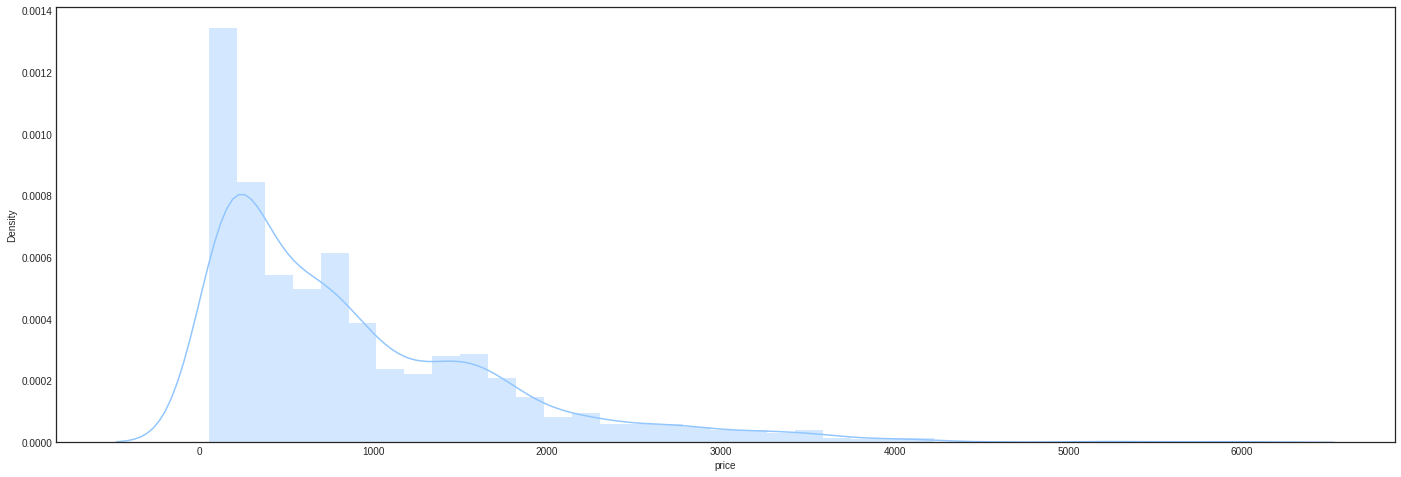

In [37]:
ax = sns.distplot(listing_BSC['price'])

- Try to transform y to log data.

In [38]:
# remove log outlier 
lower_BSC = np.log(listing_BSC["price"]).quantile(0.01)
upper_BSC = np.log(listing_BSC["price"]).quantile(0.99)
listing_BSC = listing_BSC.loc[(np.log(listing_BSC["price"]) > lower_BSC) & (np.log(listing_BSC["price"]) < upper_BSC)]

In [39]:
# Transform y to log type
y_BSC_log = np.log(listing_BSC[["price"]])
X_BSC = listing_BSC[["square_meters"]]
X_train_BSC, X_test_BSC, y_train_BSC, y_test_BSC = train_test_split(X_BSC, y_BSC_log, random_state=1)
# Fit model and predict 
lr_model_BSC = LinearRegression()
lr_model_BSC.fit(X_train_BSC, y_train_BSC)
y_pred_BSC = lr_model_BSC.predict(X_test_BSC)
# Evaluation metrics
r2_score_BSC = r2_score(y_test_BSC, y_pred_BSC)
mse_BSC = mean_squared_error(y_test_BSC, y_pred_BSC)
print("BSC model - R squared (R^2): %.2f" % r2_score_BSC)
print("BSC model - Mean Squared Error (MSE): %.2f" % mse_BSC)

BSC model - R squared (R^2): 0.96
BSC model - Mean Squared Error (MSE): 0.04


### Test for assumptions (BSC)

(1) Linearity

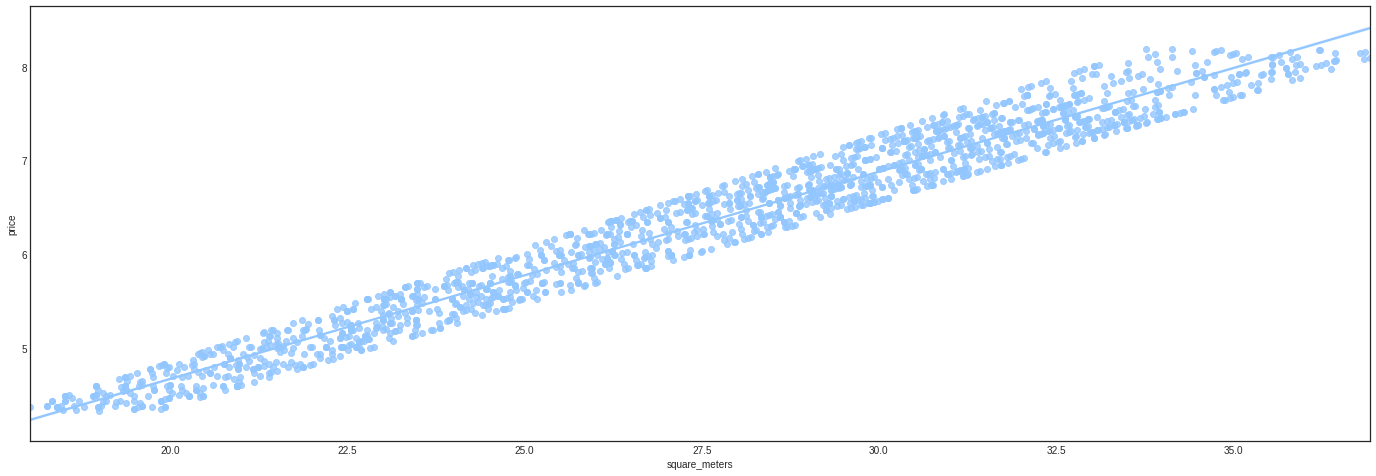

In [40]:
test_linearity(X_train_BSC, y_train_BSC, "square_meters", "price")

- have linear relationship --> ok

(2) Normality

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


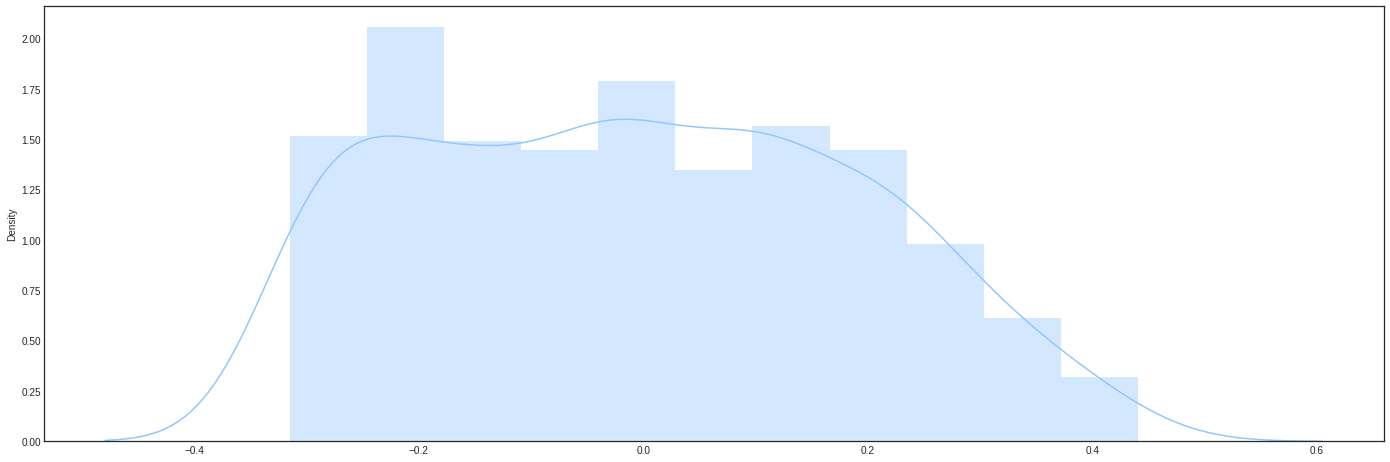

In [41]:
# calculate residuals
residuals_BSC = y_test_BSC - y_pred_BSC
sns.distplot(residuals_BSC)

residuals is not normally distributed. p value is 0.000 (alpha = 0.05)


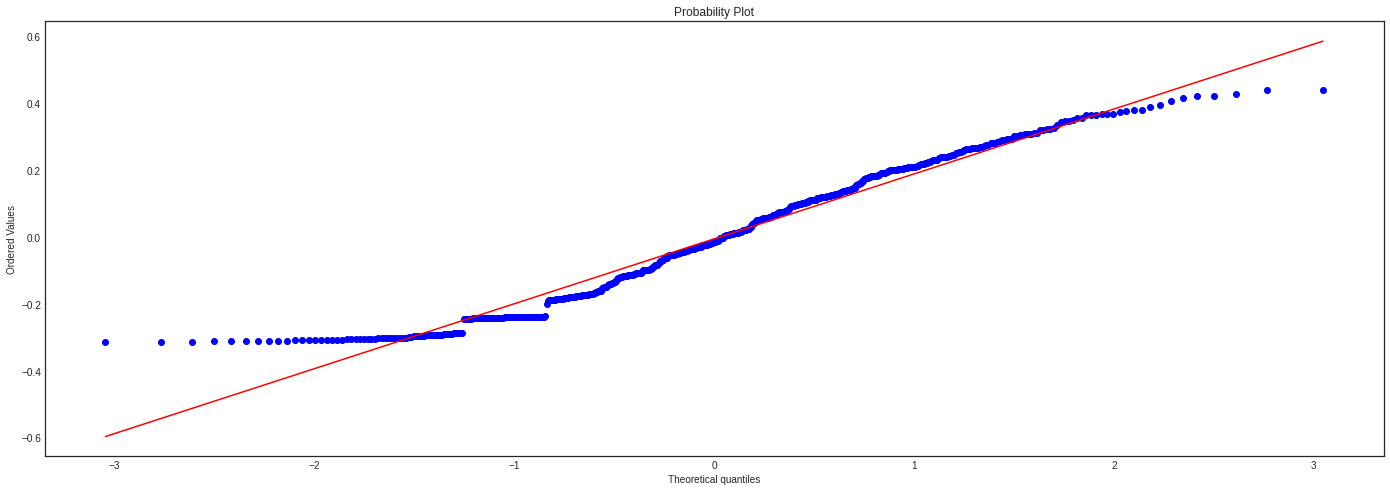

In [42]:
test_normality(residuals_BSC, "price")

- Not meet the normality assumption.

(3) No Multicollinearity
- Since I only used one predictor in this regression model, there's no need to test this assumption. --> ok

(4) No Autocorrelation

Meet assumption - little or no autocorrelation. dw_statistic is 1.879 (alpha=0.05)


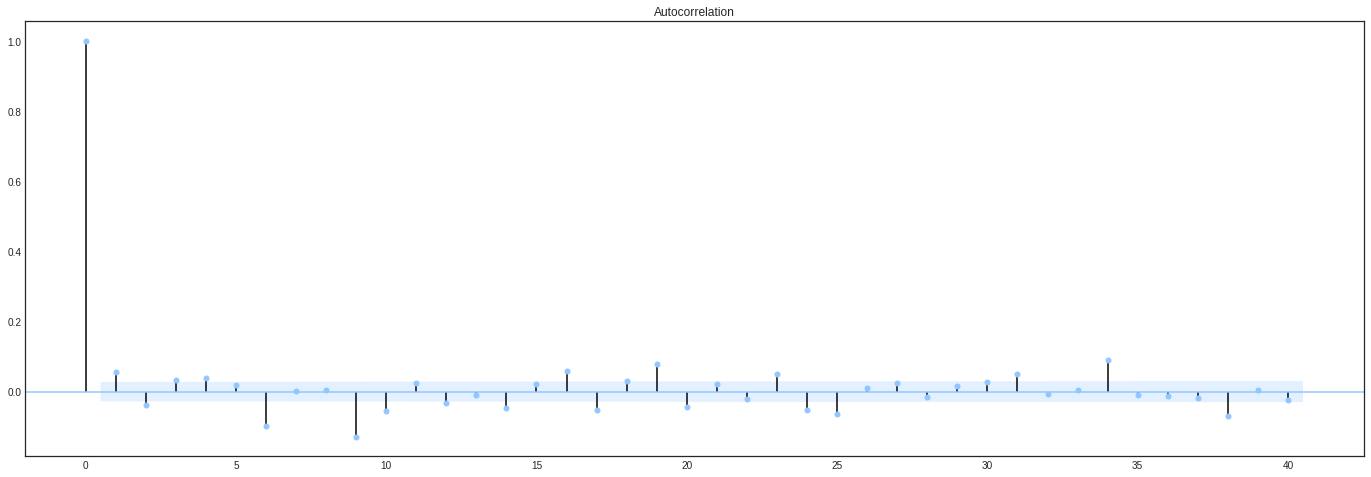

In [43]:
test_noautocorrelation(residuals_BSC)

- Meet assumption --> ok

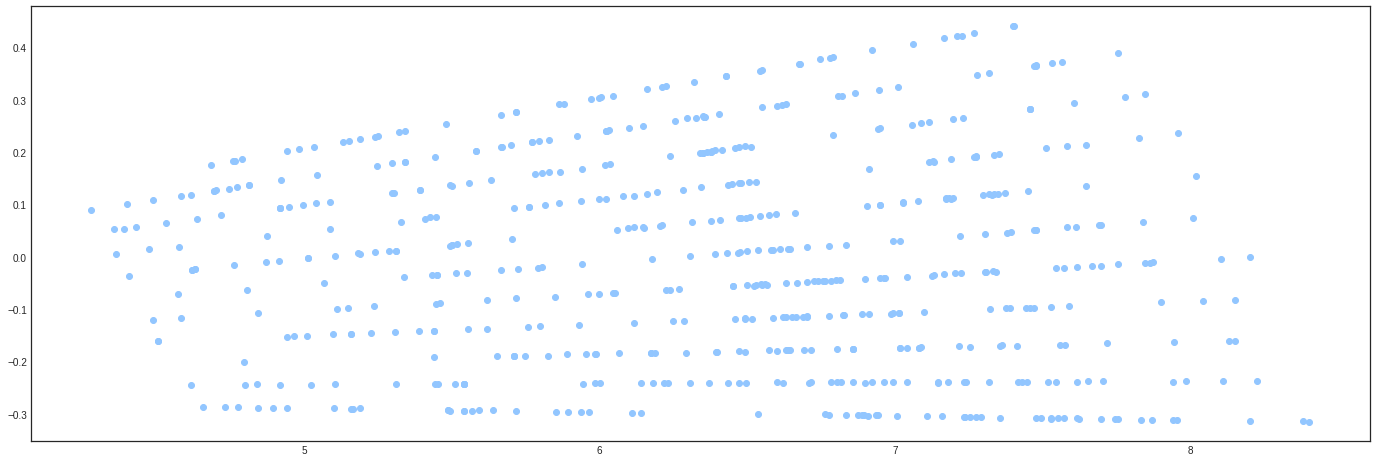

In [44]:
test_homoscedasticity(residuals_BSC, y_pred_BSC)

- From the above plot, the variance is gradually increase. However, the level of increasement is not very high. As a result, it is hard to say if this meet the assumption. 
- In my opinion, I would say this meet the homoscedasticity assumption.

**BAC model summary**   
- In this BAC model, we have a high r^2 (0.96) and a low MSE (0.04); however, this model does not meet the normality assumption. I am guessing this indicates this model is overfitting, but I am not sure whether this is the reasonable interpretation.
- I would use this model for price prediction. However, since the model does not meet the normality assumption, which means some range of data might not follow this model well, so I would be aware of this point.

## 3-3 TWEED SHIRE COUNCIL (TSC) model

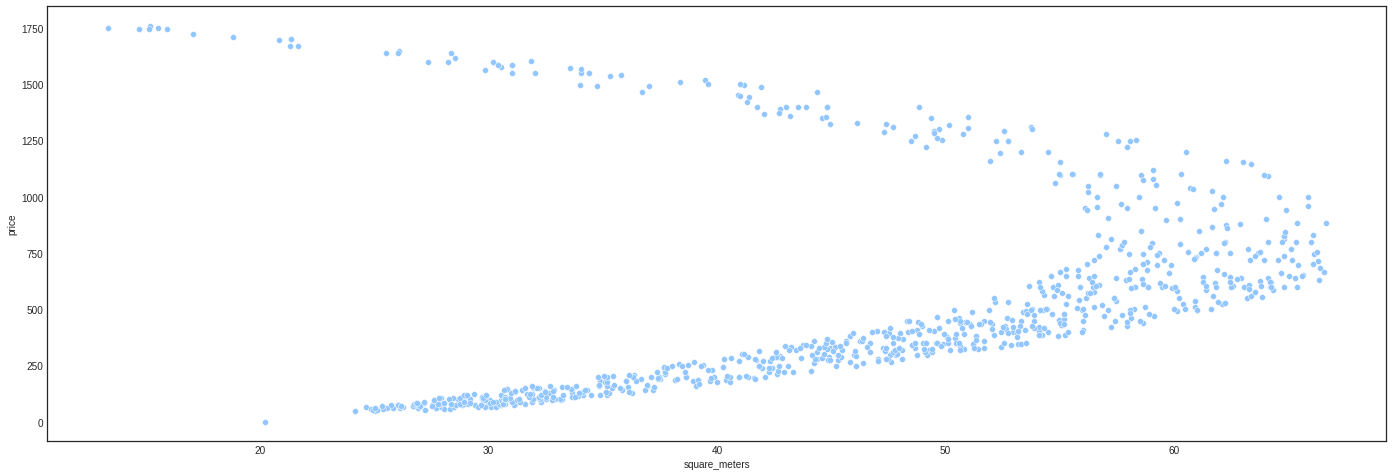

In [45]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_TSC)

In [46]:
# Remove outlier
lower_TSC = listing_TSC["square_meters"].quantile(0.01)
upper_TSC = listing_TSC["square_meters"].quantile(0.99)
listing_TSC = listing_TSC.loc[(listing_TSC["square_meters"] > lower_TSC) & (listing_TSC["square_meters"] < upper_TSC)]

In [47]:
# Transform y using PolynomialFeatures(degree=2)
pf_2 = PolynomialFeatures(degree=2)
y_TSC = pf_2.fit_transform(listing_TSC[["price"]])

**Reference**
- [Polynomial Regression](https://towardsdatascience.com/polynomial-regression-bbe8b9d97491)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


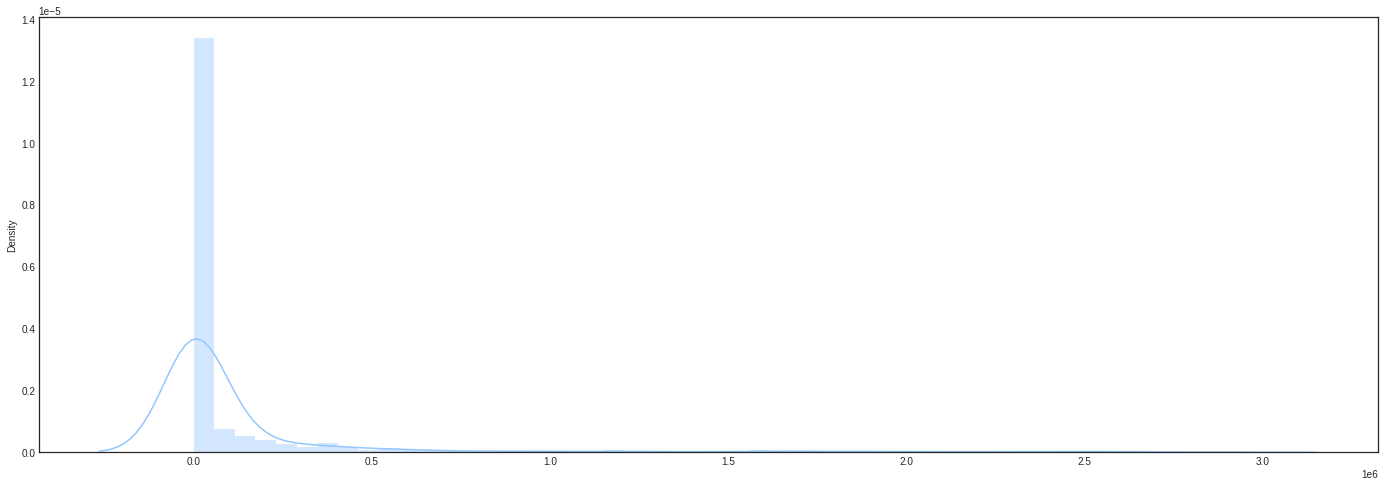

In [48]:
ax = sns.distplot(y_TSC)

In [49]:
# Transform current y_TSC to log 
y_TSC = np.log(y_TSC)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


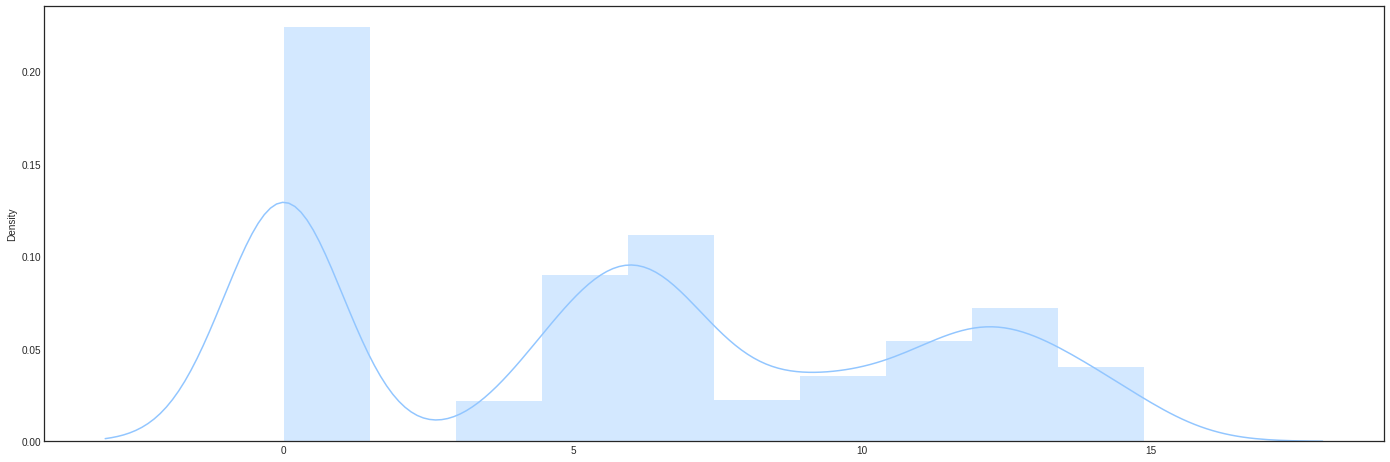

In [50]:
ax = sns.distplot(y_TSC)

In [51]:
# Transform current y_TSC using PolynomialFeatures(degree=3)
pf_3 = PolynomialFeatures(degree=3)
y_TSC = pf_3.fit_transform(y_TSC)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


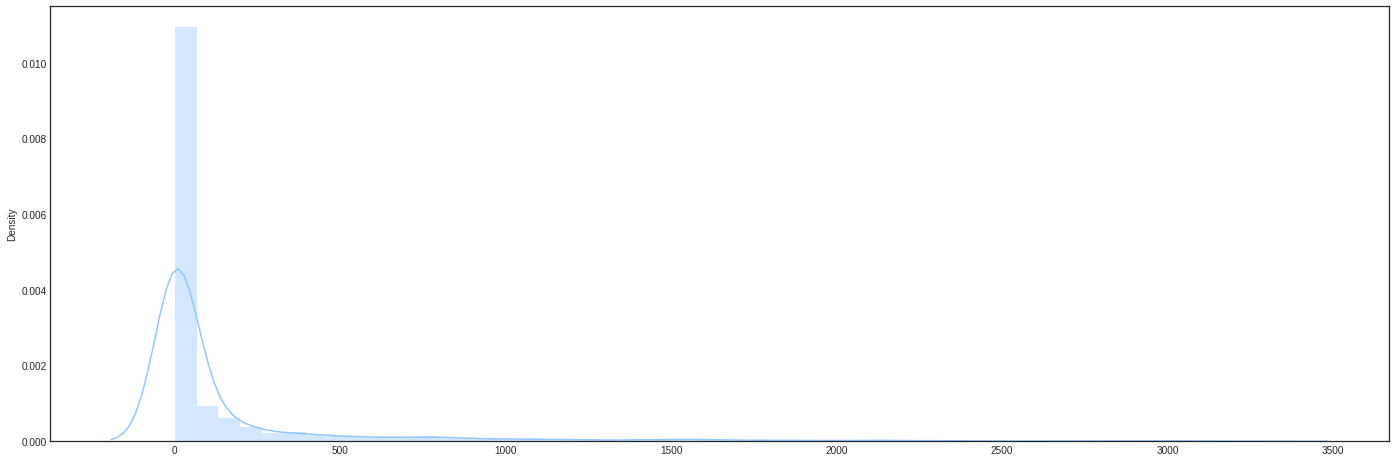

In [52]:
ax = sns.distplot(y_TSC)

In [53]:
# prepare X data 
X_TSC = listing_TSC[["square_meters"]]
X_train_TSC, X_test_TSC, y_train_TSC, y_test_TSC = train_test_split(X_TSC, y_TSC, random_state=1)
# Fit model and predict
lr_model_TSC = LinearRegression()
lr_model_TSC.fit(X_train_TSC, y_train_TSC)
y_pred_TSC = lr_model_TSC.predict(X_test_TSC)
# Evaluation metrics
r2_score_TSC = r2_score(y_test_TSC, y_pred_TSC)
mse_TSC = mean_squared_error(y_test_TSC, y_pred_TSC)
print("TSC model - R squared (R^2): %.2f" % r2_score_TSC)
print("TSC model - Mean Squared Error (MSE): %.2f" % mse_TSC)

TSC model - R squared (R^2): 0.75
TSC model - Mean Squared Error (MSE): 22632.14


## Test assumptions for TSC model

In [54]:
# Change data to dataframe type in order to use defined function
y_test_TSC_f = y_test_TSC.flatten()
y_test_TSC_df = pd.DataFrame()
y_test_TSC_df['price']=pd.Series(y_test_TSC_f)

y_pred_TSC_f = y_pred_TSC.flatten()
y_pred_TSC_df = pd.DataFrame()
y_pred_TSC_df['price'] = pd.Series(y_pred_TSC_f)

In [55]:
residual_TSC = y_test_TSC_df - y_pred_TSC_df

Normality

/usr/local/lib/python3.6/dist-packages/statsmodels/stats/_adnorm.py:67: RuntimeWarning: divide by zero encountered in log
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


residuals is not normally distributed. p value is 0.000 (alpha = 0.05)


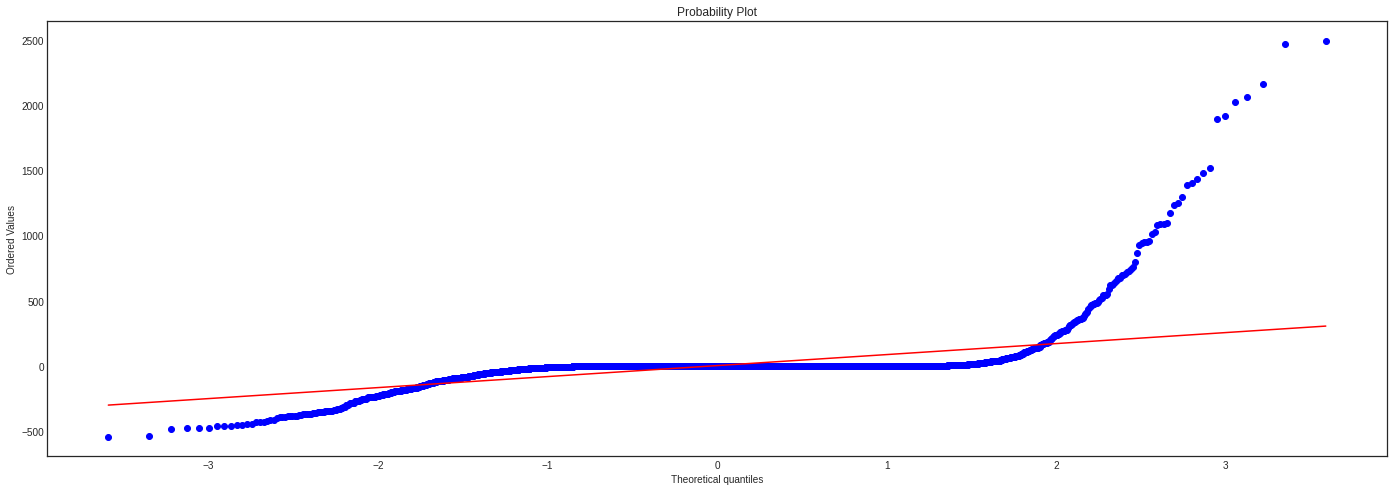

In [56]:
test_normality(residual_TSC, "price")

No Autocorrelation

Assumption not meet - positive autocorrelation. dw_statistic is 1.002 (alpha=0.05)


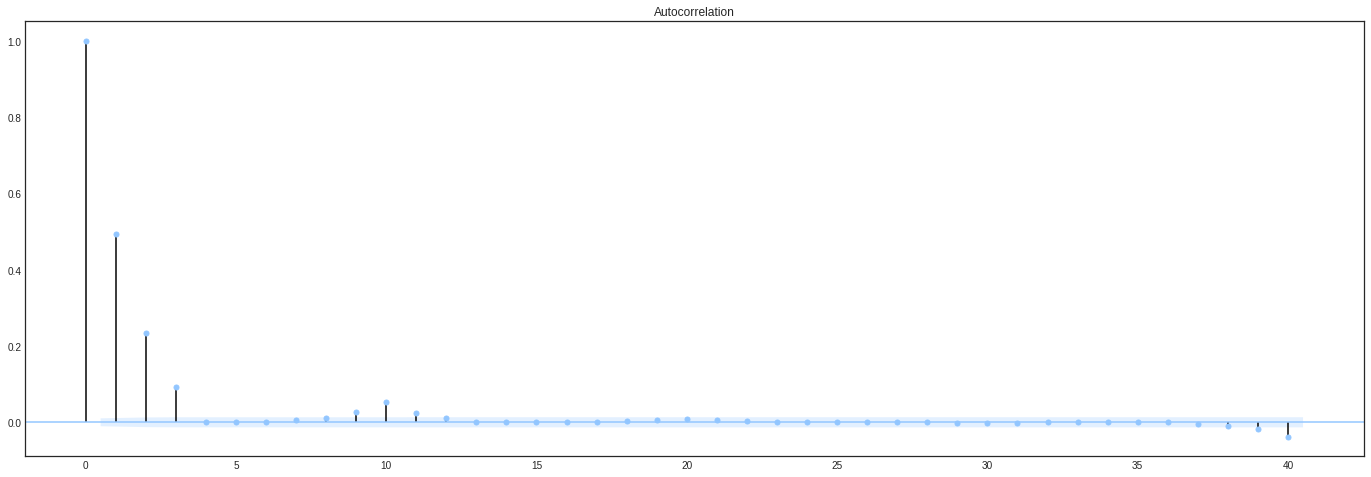

In [57]:
test_noautocorrelation(residual_TSC)

Homoscedasticity

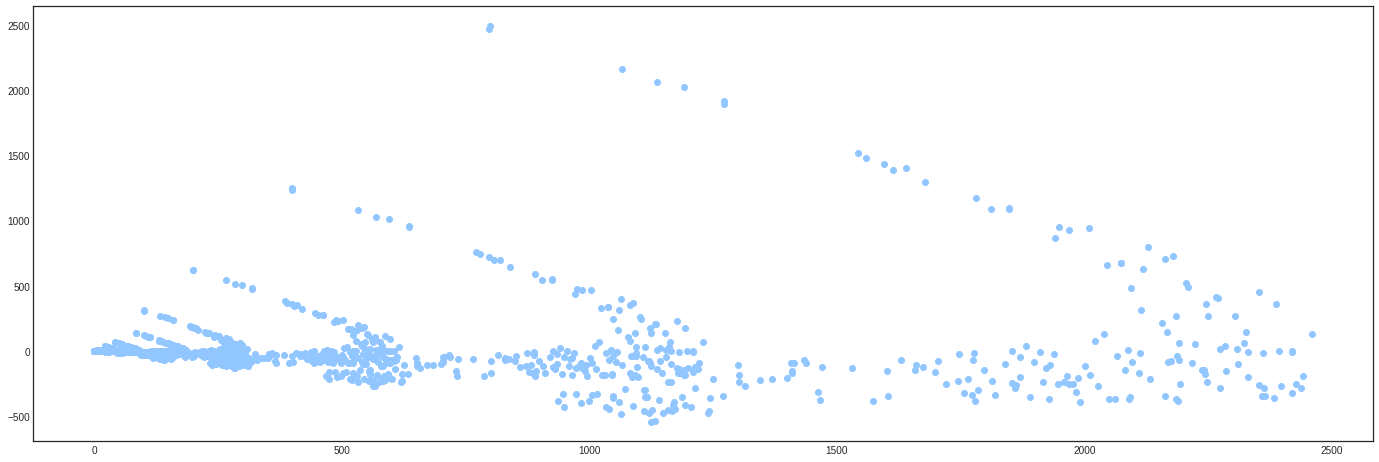

In [58]:
test_homoscedasticity(residual_TSC, y_pred_TSC_df)

 Our TSC model does not meet many assumptions. Hence, this model is not reliable.

**TSC model summary**:

- Transform dependent variable(y) as below:     
PolynomialFeatures(degree = 2) > log > PolynomialFeatures(degree = 3)

- independent variable(X): square_meters
- Fit Linear Regression model
- R squared (R^2): 0.75 ; Mean Squared Error (MSE): 22632.14
- **Does not meet the assumptions of linear regression**
> Though this model has pretty good R^2 value, it does not meet most of the assumptions, which indicates this model is not reliable.

As a result, I've tried other ways to build prediction model for TSC. However, all the trail and error failed (not applicable or very low performance score).

What I've tried (appendix):
1. Using curve_fit:
- Can not find optimal parameters for the curve 
- Though the relationship between x and y shown on the plot seems like follows the formula such as "y=sqrt(x+a)+b", it do contain too much points at the same location - which might be the reason that we can not find the optimal parameters.

2. Using SVM/SGDRegressor/KNeighborsRegressor/DecisionTreeRegressor/RandomForestRegressor  with multipe independent variables(X)
- Since I found an article said that if the model voliates the assumptions, we could try to use non-parametric analysis, so I decided to try these non-parametrics regression models. 
- All the performance are bad. (the highest one is about 0.54)
- Possible reasons:
  - I used the wrong methods to apply these models - maybe lack of some steps? lack of transforming data? 
  - These models are not suitable for this case. 
  - The data itself just that bad, or maybe need to add something for prediction.
  - others...


Prediction summary:
- If I really need to make a prediction for this area, I would use this unreliable model to predict the result. But I would also refer to the scatter plot (price versus square-meters) to see if I need to adjust my decision.  
- It seems like for this area, we could tune a better model for prediction.

In [59]:
listing["neighbourhood_cleansed"].value_counts()

BYRON SHIRE COUNCIL        2487
TWEED SHIRE COUNCIL         852
BALLINA SHIRE COUNCIL       445
LISMORE CITY COUNCIL         90
RICHMOND VALLEY COUNCIL      11
Name: neighbourhood_cleansed, dtype: int64

## 3-4 LISMORE CITY COUNCIL (LCC)

- Since LCC only have 90 datapoints, which might not suitable for building a model. As a result, I would like to see if something reasonable for predicting the price.

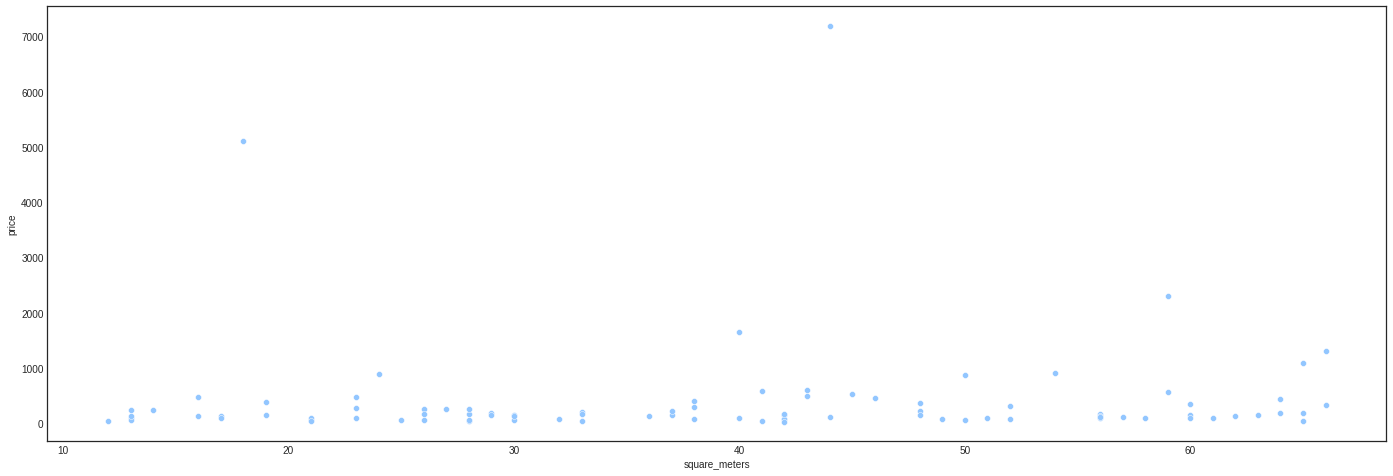

In [60]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_LCC)

In [61]:
listing_LCC["price"].describe()

count      90.000000
mean      405.111111
std       952.813073
min        30.000000
25%        99.000000
50%       151.000000
75%       329.750000
max      7190.000000
Name: price, dtype: float64

In [62]:
lower_LCC = listing_LCC["price"].quantile(0.01)
upper_LCC = listing_LCC["price"].quantile(0.99)
listing_LCC = listing_LCC.loc[(listing_LCC["price"] > lower_LCC) & (listing_LCC["price"] < upper_LCC)]

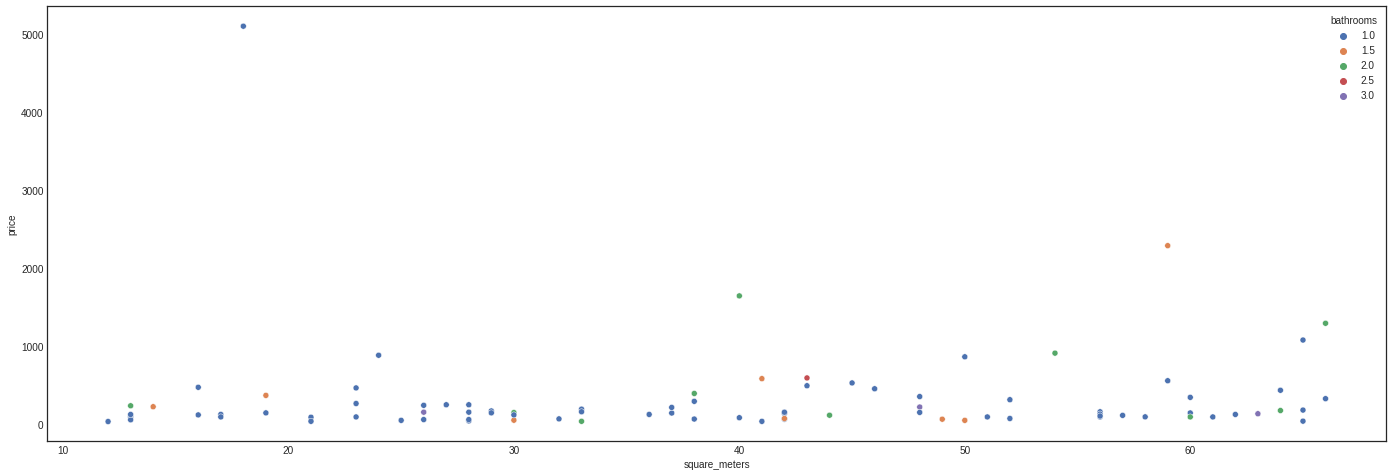

In [63]:
# To see if there's some obvious pattern in plot
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_LCC, hue="bathrooms", palette="deep")

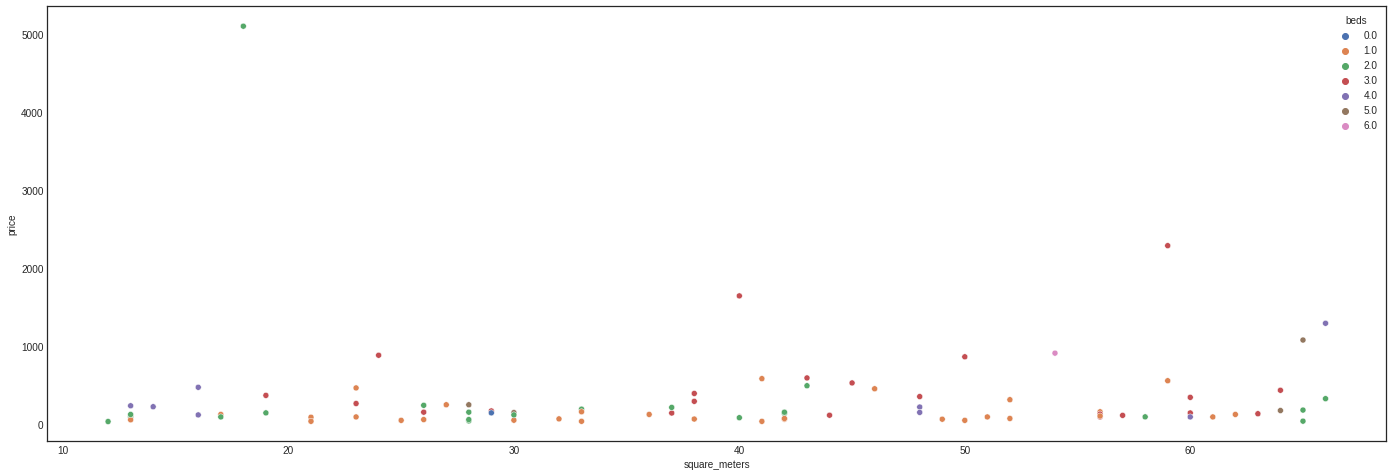

In [64]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_LCC, hue="beds", palette="deep")

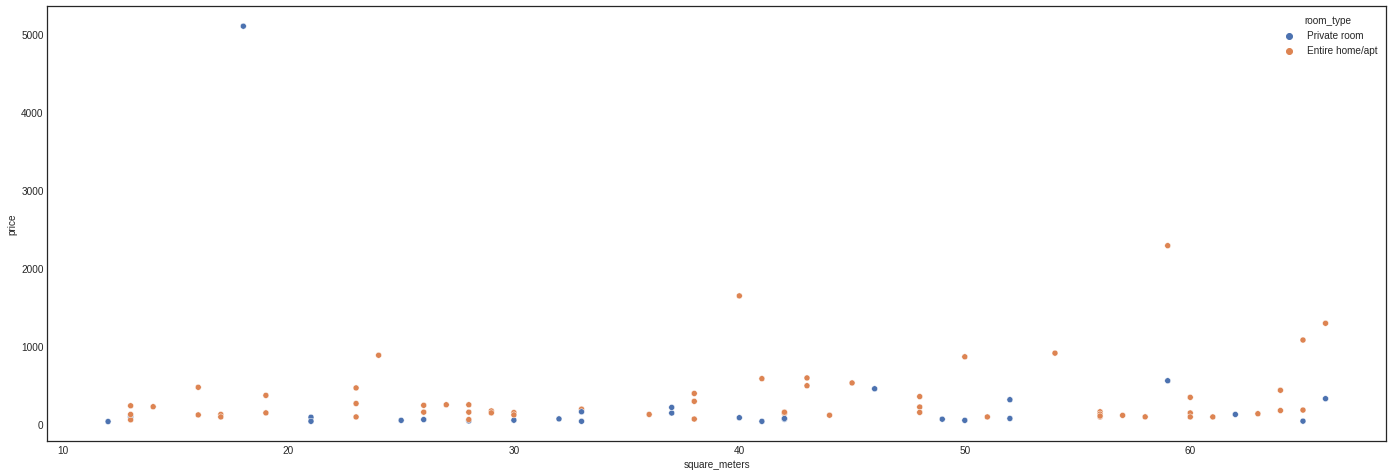

In [65]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_LCC, hue="room_type", palette="deep")

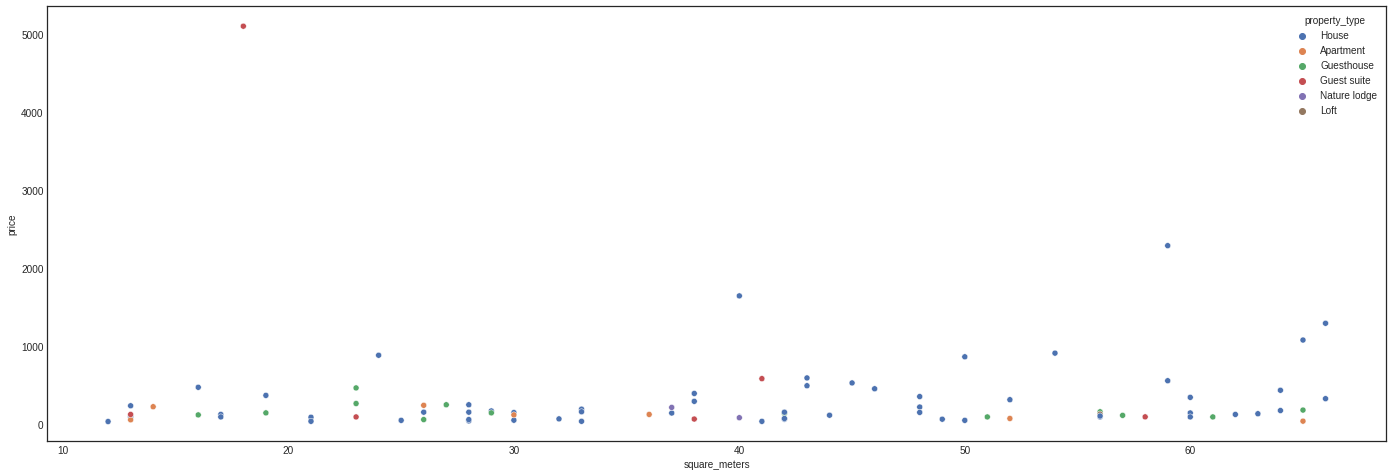

In [66]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_LCC, hue="property_type", palette="deep")

**LCC summary**
- We could not find any obvious pattern in our plot.
- The dataset is too small to build a prediction model . 
- For this area, I would say we need more data to make a price prediction. As a result, maybe we don't need to seek for prediction, just set the price based on renting knowledge or personal preference. 

## 3-5 RICHMOND VALLEY COUNCIL  (RVC)

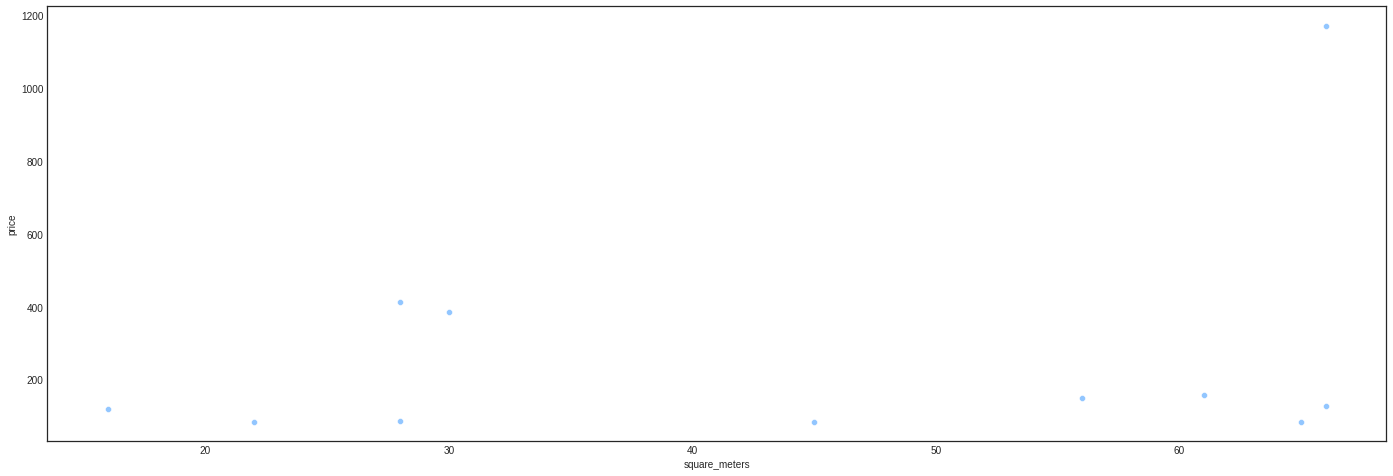

In [67]:
ax = sns.scatterplot(x="square_meters", y = "price", data=listing_RVC)

**RVC summary**
- The dataset is too small (only 11 data points!). 
- For this area, I would say we need more data to make a price prediction. As a result, maybe we don't need to seek for prediction, just set the price based on renting knowledge or personal preference. 

## Overall Summary 
In this Australia dataset, I divided data into five subset based on the neighbourhoods.    
- BASC: linear regression model with high performance. 
- BSC: linear regression model using transformed data. The model has high performance, but does not meet the normality assumption.
- TSC: linear regression model using transformed data. The model failed to meet most of the assumptions.
- LCC: dataset is too small for model building.
- RVC: dataset is too small for model building.

I would feel most comfortable to provide recommendation on BASC area; and less comfortable to provide recommendation for TSC area since the model is not reliable, and I have no other ideas to give reasonable prediction.

---------------------------------------------------------------------
## Appendix 

### TSC data - trial and error - curve fit


In [91]:
"""
# Curve fit failed - error: Optimal parameters not found

from scipy.optimize import curve_fit 

def objective(x, a, b):
  return np.sqrt(x+a)+b

xdata = listing_TSC["square_meters"]
ydata = listing_TSC["price"]

plt.plot(xdata, ydata, 'bo')
popt, pcov = curve_fit(objective,  xdata, ydata)
print(popt)
a, b = popt 
x_line = np.arange(min(xdata), max(xdata), 1)
y_line = objective(x_line, a, b)
plt.plot(x_line, y_line, '--', color='red')

ref: https://machinelearningmastery.com/curve-fitting-with-python/
"""

'\n# Curve fit failed - error: Optimal parameters not found\n\nfrom scipy.optimize import curve_fit \n\ndef objective(x, a, b):\n  return np.sqrt(x+a)+b\n\nxdata = listing_TSC["square_meters"]\nydata = listing_TSC["price"]\n\nplt.plot(xdata, ydata, \'bo\')\npopt, pcov = curve_fit(objective,  xdata, ydata)\nprint(popt)\na, b = popt \nx_line = np.arange(min(xdata), max(xdata), 1)\ny_line = objective(x_line, a, b)\nplt.plot(x_line, y_line, \'--\', color=\'red\')\n\nref: https://machinelearningmastery.com/curve-fitting-with-python/\n'

### TSC data - trial and error - try different regression models

In [92]:
"""
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor 

X_col_TSC = ['square_meters', 'bathrooms', 'beds']

#Load the X data set
X_TSC_2 = listing_TSC[X_col_TSC].values

data_length = len(listing_TSC)
column_length = len(listing_TSC[X_col_TSC].columns)

#Reshape 
X_TSC_2 = X_TSC_2.reshape(data_length,column_length)
y_TSC_2 = listing_TSC['price'].values
y_TSC_2 = y_TSC_2.reshape(data_length,1)


X_train_TSC2, X_test_TSC2, y_train_TSC2, y_test_TSC2 = train_test_split(X_TSC_2,y_TSC_2)

clf =  KernelRidge(kernel='rbf', gamma=0.01)
clf.fit(X_train_TSC2, y_train_TSC2)
y_pred_TSC2 = clf.predict(X_test_TSC2)

#print(clf.score(X_train_TSC2, y_train_TSC2))
print(r2_score(y_test_TSC2, y_pred_TSC2))
print("Accuracy:",metrics.accuracy_score(y_test_TSC2, y_pred_TSC2))

ref: https://www.statisticssolutions.com/what-to-do-when-the-assumptions-of-your-analysis-are-violated/
ref: https://www.kaggle.com/residentmario/non-parametric-regression
"""

'\nfrom sklearn import svm\nfrom sklearn import metrics\nfrom sklearn.linear_model import SGDRegressor\nfrom sklearn.svm import SVR\nfrom sklearn.neighbors import KNeighborsRegressor\nfrom sklearn.tree import DecisionTreeRegressor\nfrom sklearn.kernel_ridge import KernelRidge\nfrom sklearn.linear_model import Ridge\nfrom sklearn.ensemble import RandomForestRegressor\n\n\nX_col_TSC = [\'square_meters\', \'bathrooms\', \'beds\']\n\n#Load the X data set\nX_TSC_2 = listing_TSC[X_col_TSC].values\n\ndata_length = len(listing_TSC)\ncolumn_length = len(listing_TSC[X_col_TSC].columns)\n\n#Reshape \nX_TSC_2 = X_TSC_2.reshape(data_length,column_length)\ny_TSC_2 = listing_TSC[\'price\'].values\ny_TSC_2 = y_TSC_2.reshape(data_length,1)\n\n\nX_train_TSC2, X_test_TSC2, y_train_TSC2, y_test_TSC2 = train_test_split(X_TSC_2,y_TSC_2)\n\nclf =  KernelRidge(kernel=\'rbf\', gamma=0.01)\nclf.fit(X_train_TSC2, y_train_TSC2)\ny_pred_TSC2 = clf.predict(X_test_TSC2)\n\n#print(clf.score(X_train_TSC2, y_train_TSC2

### BSC data - transform data using TransformedTargetRegressor
- do not know why result is different from manually transform y to log(y).

In [93]:
"""
# Using "TransformedTargetRegressor" to build BSC model 
# Get different result from manually transofrmation - don't know why

y_BSC = listing_BSC[["price"]]
X_BSC = listing_BSC[["square_meters"]]
X_train_BSC, X_test_BSC, y_train_BSC, y_test_BSC = train_test_split(X_BSC, y_BSC, random_state=1)
# Transform y into log type 
lr_model_BSC = TransformedTargetRegressor(regressor = LinearRegression(),
                                       func = np.log1p,
                                       inverse_func = np.expm1)
lr_model_BSC.fit(X_train_BSC, y_train_BSC)
y_pred_BSC = lr_model_BSC.predict(X_test_BSC)
r2_score_BSC = r2_score(y_test_BSC, y_pred_BSC)
mse_BSC = mean_squared_error(y_test_BSC, y_pred_BSC)
print("BSC model - R squared (R^2): %.2f" % r2_score_BSC)
print("BSC model - Mean Squared Error (MSE): %.2f" % mse_BSC)

result:
BSC model - R squared (R^2): 0.89
BSC model - Mean Squared Error (MSE): 76177.49

ref: https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/
"""

'\n# Using "TransformedTargetRegressor" to build BSC model \n# Get different result from manually transofrmation - don\'t know why\n\ny_BSC = listing_BSC[["price"]]\nX_BSC = listing_BSC[["square_meters"]]\nX_train_BSC, X_test_BSC, y_train_BSC, y_test_BSC = train_test_split(X_BSC, y_BSC, random_state=1)\n# Transform y into log type \nlr_model_BSC = TransformedTargetRegressor(regressor = LinearRegression(),\n                                       func = np.log1p,\n                                       inverse_func = np.expm1)\nlr_model_BSC.fit(X_train_BSC, y_train_BSC)\ny_pred_BSC = lr_model_BSC.predict(X_test_BSC)\nr2_score_BSC = r2_score(y_test_BSC, y_pred_BSC)\nmse_BSC = mean_squared_error(y_test_BSC, y_pred_BSC)\nprint("BSC model - R squared (R^2): %.2f" % r2_score_BSC)\nprint("BSC model - Mean Squared Error (MSE): %.2f" % mse_BSC)\n\nresult:\nBSC model - R squared (R^2): 0.89\nBSC model - Mean Squared Error (MSE): 76177.49\n\nref: https://machinelearningmastery.com/how-to-transform